In [6]:
from typing import Annotated
from typing_extensions import TypedDict

In [7]:
### Working with Tools
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun

## Arxiv and wikipedia tools
arxiv_wrapper = ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wrapper)
wikipedia_wrapper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=300)
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wrapper)

In [8]:
wikipedia_tool.invoke("Who is Albert Einstein?")

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [5]:
arxiv_tool.invoke("Quantum Computing")

ConnectionError: HTTPSConnectionPool(host='export.arxiv.org', port=443): Max retries exceeded with url: /api/query?search_query=Quantum+Computing&id_list=&sortBy=relevance&sortOrder=descending&start=0&max_results=100 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x000001F2E3E97830>: Failed to resolve 'export.arxiv.org' ([Errno 11001] getaddrinfo failed)"))

In [9]:
tools = [arxiv_tool, wikipedia_tool]

In [10]:
## Langgraph Agent with Tools
from langgraph.graph import add_messages
class State(TypedDict):
    messages: Annotated[list, add_messages]
    

In [11]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode,tools_condition

In [12]:
graph_builder = StateGraph(State)

In [13]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
load_dotenv()

llm = ChatGroq(model="openai/gpt-oss-120b")

In [14]:
llm_with_tools = llm.bind_tools(tools=tools)

In [15]:
def chatbot(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [16]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot",tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("chatbot", END)

In [17]:
graph = graph_builder.compile()

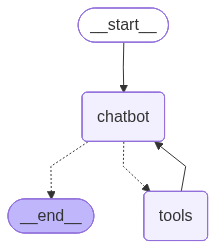

In [18]:
from IPython.display import display, Image
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
user_input = "explain about quantum computing and cite a research paper from arxiv"
events = graph.stream(
    {"messages":[("user", user_input)]}, stream_mode="values"
)

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

explain about quantum computing and cite a research paper from arxiv
================================== Ai Message ==================================
Tool Calls:
  arxiv (fc_0b993d8f-08f0-4613-8c79-cf11d16741ee)
 Call ID: fc_0b993d8f-08f0-4613-8c79-cf11d16741ee
  Args:
    query: quantum computing review
================================= Tool Message =================================
Name: arxiv

Published: 2008-12-02
Title: Quantum algorithms for algebraic problems
Authors: Andrew M. Childs, Wim van Dam
Summary: Quantum computers can execute algorithms that dramatically outperform
classical computation. As the best-known example, Shor discovered an efficient
quantum algorithm for factoring 
================================== Ai Message ==================================

**Quantum Computing – A Brief Overview**

Quantum computing is a paradigm of information processing that exploits the principles of qua